In [ ]:
#Para graficar palabras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Vectores TF-IDF

In [ ]:
#Instancia clase tfidf 

Gráficamos los vectores de TF-IDF de cada oración 

In [ ]:
def get_vectors():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for chanel in tqdm(videos):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    vectors[" ".join(s["text"])] = s["tfid"]
    return vectors

100%|██████████| 9/9 [00:00<00:00, 15.19it/s]
10it [00:00, 6644.97it/s]


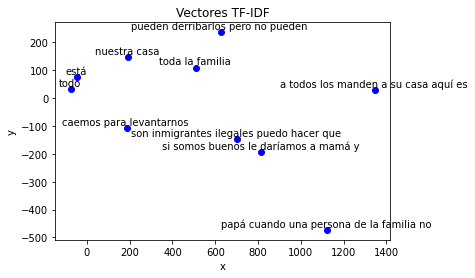

In [ ]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(X,ids):
    '''
    Gráfica las oraciones dado su vector tfid

    Args:
        X (list): coordenadas del vector aplicando PCA
        ids (list): oraciones
    '''
    r=0
    plt.scatter(X[:,0],X[:,1], marker='o', c='blue')
    for label,x,y in tqdm(zip(ids, X[:,0], X[:,1])):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
        
mds_model = PCA(n_components=2)
vectors = get_vectors()
X_pca = mds_model.fit_transform(list(vectors.values()))
#Solo se gráfican algunas oraciones
plot_words(X_pca[20:30], list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF')
plt.xlabel('x')
plt.ylabel('y')
plt.show()